In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===== MIF Module =====
class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv288 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv144 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv72 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv36 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x288 = x
        x144 = F.interpolate(x, size=(144, 144), mode='bilinear', align_corners=True)
        x72 = F.interpolate(x, size=(72, 72), mode='bilinear', align_corners=True)
        x36 = F.interpolate(x, size=(36, 36), mode='bilinear', align_corners=True)

        s288 = self.conv288(x288)
        s144 = self.conv144(x144)
        s72 = self.conv72(x72)
        s36 = self.conv36(x36)

        return s288, s144, s72, s36
# ===== Res2Block + SEBlock =====
class Res2Block(nn.Module):
    def __init__(self, in_channels, out_channels, scale=4):
        super().__init__()
        assert in_channels % scale == 0
        self.scale = scale
        self.width = in_channels // scale

        self.conv1x1_in = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.width, self.width, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(self.width),
                nn.ReLU(inplace=True)
            ) for _ in range(scale - 1)
        ])

        self.conv1x1_out = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn_out = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1x1_in(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]

        for i in range(1, self.scale):
            if i == 1:
                y = self.convs[i - 1](splits[i])
            else:
                y = self.convs[i - 1](splits[i] + outputs[-1])
            outputs.append(y)

        out = torch.cat(outputs, dim=1)
        out = self.conv1x1_out(out)
        out = self.bn_out(out)
        out += identity
        return self.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2SEBlock(nn.Module):
    def __init__(self, channels, dropout=0.3):
        super().__init__()
        self.res2 = Res2Block(channels, channels)
        self.se = SEBlock(channels)
        self.dropout = nn.Dropout2d(dropout)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.res2(x)
        out = self.se(out)
        out = self.dropout(out)
        out = self.bn(out)
        out = self.relu(out)
        return out + identity
# ===== PDC Block =====
class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch2_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch2_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch3_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch4_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=8, dilation=8),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv4 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.fuse = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)

        b2 = self.branch2_conv2(self.branch2_conv1(x))

        b3_1 = self.branch3_conv1(x)
        b3_2 = self.branch3_conv2(b3_1)
        b3 = self.branch3_conv3(b3_1 + b3_2)

        b4_1 = self.branch4_conv1(x)
        b4_2 = self.branch4_conv2(b4_1)
        b4_3 = self.branch4_conv3(b4_2 + b4_1)
        b4 = self.branch4_conv4(b4_3 + b4_2 + b4_1)

        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)
# ===== Final MRP_UNet Model =====
class MRP_UNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.mif = MIFModule()

        # Main encoder
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)

        # Side encoders (for MIF features)
        self.side_enc2 = Res2SEBlock(64)
        self.side_enc3 = Res2SEBlock(128)
        self.side_enc4 = Res2SEBlock(256)

        # Bottleneck
        self.bottleneck_pre = Res2SEBlock(512)
        self.pdc = PDCBlock(512, 512)
        self.bottleneck_post = Res2SEBlock(512)

        # Decoder
        self.dec4 = self.decoder_block(1024, 512, 256)
        self.dec3 = self.decoder_block(512, 256, 128)
        self.dec2 = self.decoder_block(256, 128, 64)
        self.dec1 = self.decoder_block(128, 64, 64)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def decoder_block(self, in_ch, mid_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):  # [B, 3, 288, 288]
        s288, s144, s72, s36 = self.mif(x)

        # Encoder
        e1 = self.enc1(s288)
        skip1 = e1
        x = F.max_pool2d(e1, 2)

        s144 = self.side_enc2(s144)
        x = torch.cat([x, s144], dim=1)
        e2 = self.enc2(x)
        skip2 = e2
        x = F.max_pool2d(e2, 2)

        s72 = self.side_enc3(s72)
        x = torch.cat([x, s72], dim=1)
        e3 = self.enc3(x)
        skip3 = e3
        x = F.max_pool2d(e3, 2)

        s36 = self.side_enc4(s36)
        x = torch.cat([x, s36], dim=1)
        e4 = self.enc4(x)
        skip4 = e4
        x = F.max_pool2d(e4, 2)

        # Bottleneck
        x = self.bottleneck_pre(x)
        x = self.pdc(x)
        x = self.bottleneck_post(x)

        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip4], dim=1)
        x = self.dec4(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], dim=1)
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)
        x = self.dec1(x)

        return self.final(x)  # [B, num_classes, 288, 288]


In [4]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Create output folder
os.makedirs("fine_masks", exist_ok=True)

# Image and mask directories
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
model_path = "/kaggle/input/new_model/pytorch/default/1/best_model(7).pth"


In [6]:
class ISICDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_names = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.transform = transform or transforms.Compose([
            transforms.Resize((288, 288)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        return self.transform(img), img_name

    def __len__(self):
        return len(self.image_names)


In [8]:
dataset = ISICDataset(img_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)


In [9]:
model = MRP_UNet(num_classes=2)
state_dict = torch.load(model_path, map_location='cuda')
model.load_state_dict(state_dict)
model.eval().cuda()


MRP_UNet(
  (mif): MIFModule(
    (conv288): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv144): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv72): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv36): Sequential(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (enc1): Res2SEBlock(
    (res2): Res2Block(
      (conv1x1_in): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv1x1_out): Conv2d(64, 64, kernel_size=

In [10]:
def save_mask(tensor, path):
    """Save binary mask (1-channel) as PNG"""
    mask = (tensor.squeeze().cpu().numpy() * 255).astype(np.uint8)
    Image.fromarray(mask).save(path)

with torch.no_grad():
    for imgs, names in tqdm(dataloader):
        imgs = imgs.cuda()
        logits = model(imgs)               # [B, 2, H, W]
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)  # [B, H, W]

        for pred, name in zip(preds, names):
            out_path = f"fine_masks/{name.replace('.jpg', '.png')}"
            save_mask(pred.float(), out_path)


100%|██████████| 500/500 [05:32<00:00,  1.50it/s]


In [11]:
import cv2
import os
from tqdm import tqdm

input_dir = "fine_masks"
output_dir = "coarse_masks"
os.makedirs(output_dir, exist_ok=True)

def blur_and_binarize(input_path, output_path, kernel_size=15, threshold=127):
    """
    Applies Gaussian blur to a binary mask and saves the binarized result.
    """
    mask = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Failed to read {input_path}")
        return

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)

    # Binarize: threshold to remove soft edges
    _, binary_mask = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)

    cv2.imwrite(output_path, binary_mask)

# Apply to all fine masks
for fname in tqdm(os.listdir(input_dir)):
    if not fname.endswith(".png"):
        continue
    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)
    blur_and_binarize(in_path, out_path)


100%|██████████| 2000/2000 [00:02<00:00, 685.25it/s]


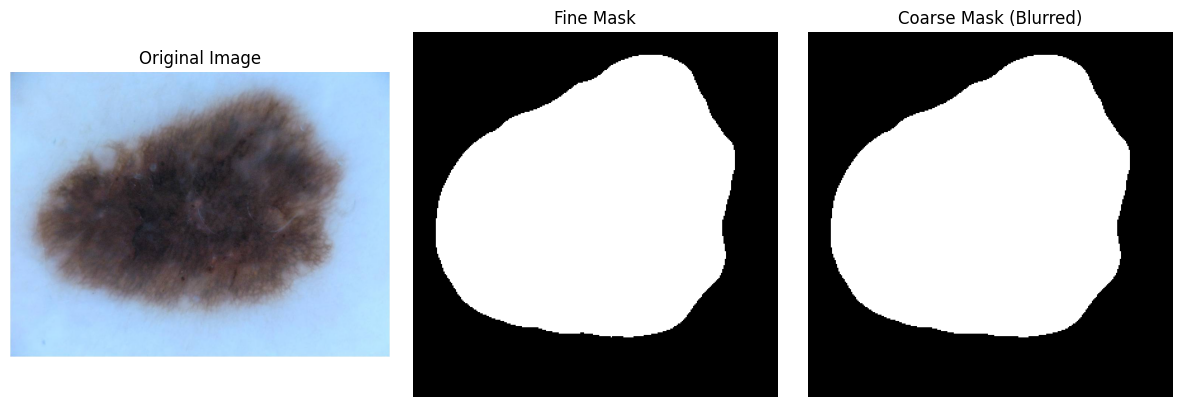

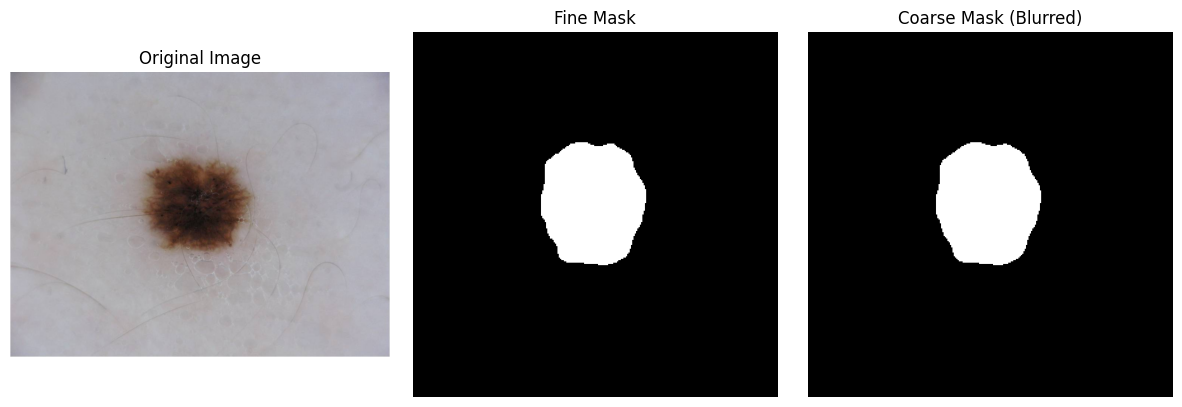

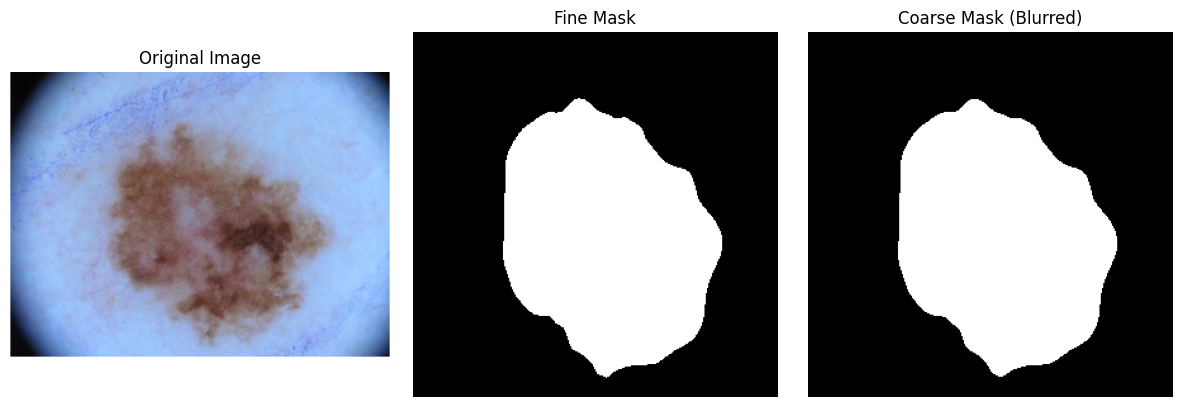

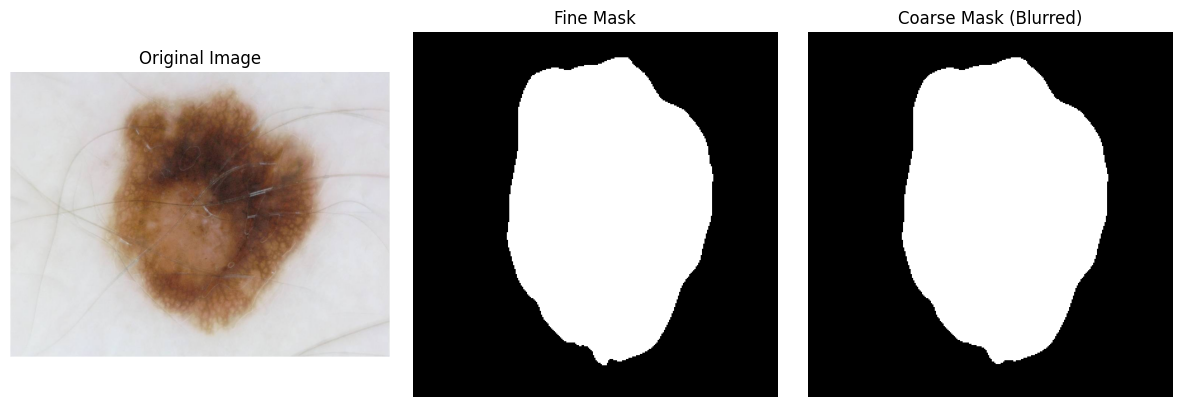

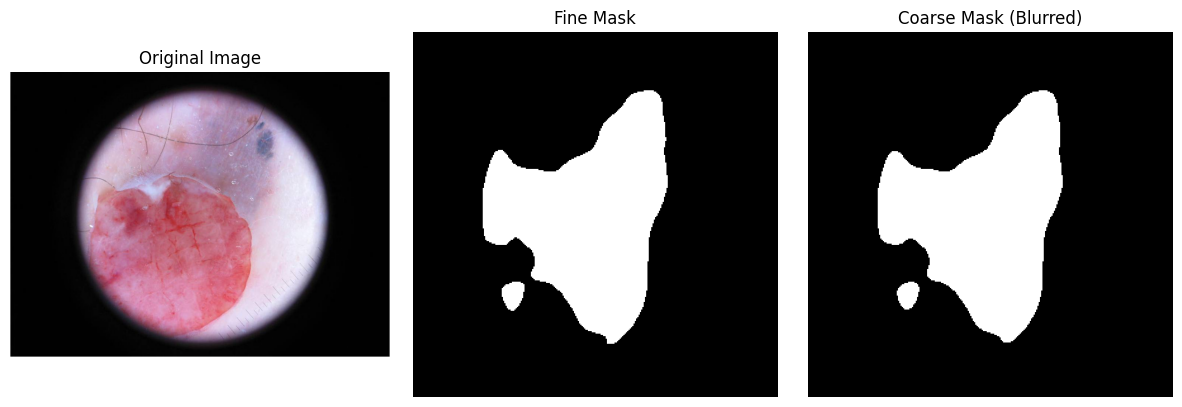

In [25]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Directories
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
fine_dir = "fine_masks"
coarse_dir = "coarse_masks"

# Get a few sample filenames (change as needed)
sample_files = sorted([f for f in os.listdir(fine_dir) if f.endswith(".png")])[:5]

for fname in sample_files:
    # Load image and masks
    img_path = os.path.join(img_dir, fname.replace(".png", ".jpg"))
    fine_path = os.path.join(fine_dir, fname)
    coarse_path = os.path.join(coarse_dir, fname)

    # Load using PIL for RGB, OpenCV for masks
    image = np.array(Image.open(img_path).convert("RGB"))
    fine_mask = cv2.imread(fine_path, cv2.IMREAD_GRAYSCALE)
    coarse_mask = cv2.imread(coarse_path, cv2.IMREAD_GRAYSCALE)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(fine_mask, cmap="gray")
    plt.title("Fine Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(coarse_mask, cmap="gray")
    plt.title("Coarse Mask (Blurred)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [26]:
import pandas as pd

# Load CSV
df = pd.read_csv("/kaggle/input/isic-2017/ISIC-2017_Training_Part3_GroundTruth.csv")

# Add 'filename' column
df["filename"] = df["image_id"] + ".jpg"

# Compute third class: nevus = 1 - MEL - SK
df["nevus"] = 1.0 - df["melanoma"] - df["seborrheic_keratosis"]

# Find dominant class
df["label"] = df[["melanoma", "nevus", "seborrheic_keratosis"]].idxmax(axis=1)

# Map class labels to numeric
class_map = {"melanoma": 0, "nevus": 1, "seborrheic_keratosis": 2}
df["label_idx"] = df["label"].map(class_map)

df.head()


,image_id,melanoma,seborrheic_keratosis,filename,nevus,label,label_idx
0,ISIC_0000000,0.0,0.0,ISIC_0000000.jpg,1.0,nevus,1
1,ISIC_0000001,0.0,0.0,ISIC_0000001.jpg,1.0,nevus,1
2,ISIC_0000002,1.0,0.0,ISIC_0000002.jpg,0.0,melanoma,0
3,ISIC_0000003,0.0,0.0,ISIC_0000003.jpg,1.0,nevus,1
4,ISIC_0000004,1.0,0.0,ISIC_0000004.jpg,0.0,melanoma,0


In [27]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import os

class MaskCNDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485]*4, std=[0.229]*4)
        ])
        self.resize = transforms.Resize((288, 288))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row.filename)
        mask_path = os.path.join(self.mask_dir, row.filename.replace(".jpg", ".png"))

        # Load image and mask, resize both to 288×288
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        img = self.resize(img)
        mask = self.resize(mask)

        # Convert to numpy
        img_np = np.array(img).astype("float32") / 255.0  # [H, W, 3]
        mask_np = np.array(mask).astype("float32") / 255.0  # [H, W]
        mask_np = np.expand_dims(mask_np, axis=-1)  # [H, W, 1]

        # Combine to 4-channel image
        img4_np = np.concatenate([img_np, mask_np], axis=-1)  # [H, W, 4]
        img4_pil = Image.fromarray((img4_np * 255).astype("uint8"))

        # Apply final transform (ToTensor + Normalize)
        img4_tensor = self.transform(img4_pil)

        label = row.label_idx
        return img4_tensor, label

    def __len__(self):
        return len(self.df)


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

In [33]:

image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
coarse_mask_dir = "coarse_masks"

#dataset = MaskCNDataset(df, image_dir, coarse_mask_dir, transform=transform)
#dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [23]:
for x, y in dataloader:
    print("Input shape:", x.shape)   # [B, 4, 288, 288]
    print("Labels:", y)              # [B]
    break


Input shape: torch.Size([4, 3, 288, 288])
Labels: ('ISIC_0000000.jpg', 'ISIC_0000001.jpg', 'ISIC_0000002.jpg', 'ISIC_0000003.jpg')


In [35]:


features_blobs = []

class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskCN, self).__init__()
        self.backbone = timm.create_model("legacy_xception", pretrained=True, num_classes=0, features_only=False)

        # Modify first conv layer for 4 channels
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight
            self.backbone.conv1.weight[:, 3:] = old_conv.weight[:, :1]  # duplicate channel

        # Final classifier head
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)

        # Register CAM hook from final block
        self.backbone.global_pool.register_forward_hook(self._hook_feature)

    def _hook_feature(self, module, input, output):
        features_blobs.clear()
        features_blobs.append(input[0])  # Input to GAP is [B,C,H,W]

    def forward(self, x):
        feats = self.backbone(x)  # [B, num_features]
        out = self.classifier(feats)
        return out

def generate_cam(model, input_tensor, class_idx=None):
    model.eval()
    features_blobs.clear()

    with torch.no_grad():
        logits = model(input_tensor.unsqueeze(0).to(next(model.parameters()).device))
        pred_idx = logits.argmax(dim=1).item() if class_idx is None else class_idx

    feature_map = features_blobs[0].squeeze(0)  # [C, H, W]
    weights = model.classifier.weight[pred_idx]  # [C]

    cam = torch.sum(weights[:, None, None] * feature_map, dim=0).detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam

def show_cam(input_tensor, cam, figsize=(12, 4)):
    rgb = input_tensor[:3].permute(1, 2, 0).cpu().numpy()
    rgb = (rgb - rgb.min()) / (rgb.max() + 1e-8)

    cam_resized = cv2.resize(cam, (rgb.shape[1], rgb.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * 0.5 + rgb * 0.5

    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1); plt.imshow(rgb); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(cam_resized, cmap='jet'); plt.title("CAM"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout()
    plt.show()


In [34]:
# # 1. Instantiate and load model
# model = MaskCN(num_classes=3).to("cuda" if torch.cuda.is_available() else "cpu")

# # 2. Pass a 4-channel tensor (from your MaskCNDataset)
# x, y = dataset[0]  # Single 4-channel input and label

# # 3. Generate CAM and visualize
# cam = generate_cam(model, x)
# show_cam(x, cam)


In [36]:
import os
from tqdm import tqdm
from torchvision.utils import save_image

def save_cams_for_dataset(model, dataset, save_dir, device='cuda'):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device).eval()
    print(f"Saving CAMs to: {save_dir}")

    for idx in tqdm(range(len(dataset))):
        img4, label = dataset[idx]  # [4, H, W], int
        filename = dataset.df.iloc[idx].filename.replace(".jpg", ".png")
        input_tensor = img4.to(device)

        cam = generate_cam(model, input_tensor, class_idx=label)
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename)

        # Save as grayscale .png
        save_image(cam_tensor, save_path)


In [38]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(288, 288),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [39]:
from sklearn.model_selection import train_test_split

# Split the dataframe
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label_idx"], random_state=42)

# Create datasets
train_dataset = MaskCNDataset(train_df, image_dir, coarse_mask_dir, transform=transform)
val_dataset   = MaskCNDataset(val_df, image_dir, coarse_mask_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MaskCN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)



In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MaskCN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [60]:
best_val_acc = 0.0

for epoch in range(20):
    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # --- Validation ---
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mask_cn_best_val.pth")
        print("  Best model saved!")


[Epoch 1] Train Loss: 73.8889 | Train Acc: 0.6844 | Val Loss: 14.4654 | Val Acc: 0.7725
  Best model saved!
[Epoch 2] Train Loss: 39.8438 | Train Acc: 0.8413 | Val Loss: 15.0254 | Val Acc: 0.7750
  Best model saved!
[Epoch 3] Train Loss: 16.5578 | Train Acc: 0.9487 | Val Loss: 18.0027 | Val Acc: 0.7575
[Epoch 4] Train Loss: 9.4812 | Train Acc: 0.9731 | Val Loss: 17.9735 | Val Acc: 0.7775
  Best model saved!
[Epoch 5] Train Loss: 7.3114 | Train Acc: 0.9775 | Val Loss: 20.0386 | Val Acc: 0.7500
[Epoch 6] Train Loss: 5.9998 | Train Acc: 0.9819 | Val Loss: 19.2427 | Val Acc: 0.7700
[Epoch 7] Train Loss: 5.6446 | Train Acc: 0.9838 | Val Loss: 20.0209 | Val Acc: 0.7975
  Best model saved!
[Epoch 8] Train Loss: 2.8011 | Train Acc: 0.9950 | Val Loss: 21.6510 | Val Acc: 0.7575
[Epoch 9] Train Loss: 2.3066 | Train Acc: 0.9950 | Val Loss: 24.6284 | Val Acc: 0.7825
[Epoch 10] Train Loss: 2.8447 | Train Acc: 0.9919 | Val Loss: 21.5927 | Val Acc: 0.7975
[Epoch 11] Train Loss: 1.9512 | Train Acc: 0.9

KeyboardInterrupt: 

In [61]:
# Trained mask-CN model with weights
model = MaskCN(num_classes=3)
model.load_state_dict(torch.load("/kaggle/working/mask_cn_best_val.pth", map_location='cpu'))  # set your path

# Save CAMs here
cam_save_dir = "/kaggle/working/fine_cams"

# Run CAM extractor
save_cams_for_dataset(model, dataset, cam_save_dir)


Saving CAMs to: /kaggle/working/fine_cams


100%|██████████| 2000/2000 [03:45<00:00,  8.86it/s]


In [90]:
model.load_state_dict(torch.load("mask_cn_best_val.pth"))
model.eval()
def save_cams_for_dataset(model, dataset, save_dir, device='cuda'):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device).eval()
    print(f"Saving CAMs to: {save_dir}")

    for idx in tqdm(range(len(dataset))):
        img4, label = dataset[idx]  # [4, H, W], int
        filename = dataset.df.iloc[idx].filename.replace(".jpg", ".png")
        input_tensor = img4.to(device)

        cam = generate_cam(model, input_tensor, class_idx=label)
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename)

        # Save as grayscale .png
        save_image(cam_tensor, save_path)
save_dir = "cam_heatmaps"
save_cams_for_dataset(model, train_dataset, save_dir, device)
save_cams_for_dataset(model, val_dataset, "cam_heatmaps_val", device)


Saving CAMs to: cam_heatmaps


100%|██████████| 1600/1600 [02:59<00:00,  8.92it/s]


Saving CAMs to: cam_heatmaps_val


100%|██████████| 400/400 [00:47<00:00,  8.49it/s]


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedSN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.mif = MIFModule()
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)

        self.side_enc2 = Res2SEBlock(64)
        self.side_enc3 = Res2SEBlock(128)
        self.side_enc4 = Res2SEBlock(256)

        self.bottleneck_pre = Res2SEBlock(512)
        self.pdc = PDCBlock(512, 512)
        self.bottleneck_post = Res2SEBlock(512)

        # --- E-layer: 1x1 Conv to fuse features + CAM ---
        self.e_layer = nn.Sequential(
            nn.Conv2d(512 + 1, 256, kernel_size=1),  # 512 from encoder + 1 CAM
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        #  Fixed Decoder input channels
        self.dec4 = self.decoder_block(768, 256, 128)  # 256 + 512
        self.dec3 = self.decoder_block(384, 128, 64)   # 128 + 256
        self.dec2 = self.decoder_block(192, 64, 32)    # 64 + 128
        self.dec1 = self.decoder_block(96, 32, 32)     # 32 + 64

        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def decoder_block(self, in_ch, mid_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, cam):
        s288, s144, s72, s36 = self.mif(x)

        e1 = self.enc1(s288)
        x = F.max_pool2d(e1, 2)  # [B, 64, 144, 144]

        s144 = self.side_enc2(s144)
        x = torch.cat([x, s144], dim=1)  # [B, 128, 144, 144]
        e2 = self.enc2(x)
        x = F.max_pool2d(e2, 2)  # [B, 128, 72, 72]

        s72 = self.side_enc3(s72)
        x = torch.cat([x, s72], dim=1)  # [B, 256, 72, 72]
        e3 = self.enc3(x)
        x = F.max_pool2d(e3, 2)  # [B, 256, 36, 36]

        s36 = self.side_enc4(s36)
        x = torch.cat([x, s36], dim=1)  # [B, 512, 36, 36]
        e4 = self.enc4(x)
        x = F.max_pool2d(e4, 2)  # [B, 512, 18, 18]

        x = self.bottleneck_pre(x)
        x = self.pdc(x)
        x = self.bottleneck_post(x)

        # --- E-layer fusion ---
        cam_resized = F.interpolate(cam, size=x.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, cam_resized], dim=1)  # [B, 513, 18, 18]
        x = self.e_layer(x)  # [B, 256, 18, 18]

        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # → [B, 256, 36, 36]
        x = torch.cat([x, e4], dim=1)  # → [B, 768, 36, 36]
        x = self.dec4(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # → [B, 128, 72, 72]
        x = torch.cat([x, e3], dim=1)  # → [B, 384, 72, 72]
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # → [B, 64, 144, 144]
        x = torch.cat([x, e2], dim=1)  # → [B, 192, 144, 144]
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # → [B, 32, 288, 288]
        x = torch.cat([x, e1], dim=1)  # → [B, 96, 288, 288]
        x = self.dec1(x)

        return self.final(x)  # → [B, num_classes, 288, 288]


In [41]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import torch

# CAM transformation to match bottleneck feature size
cam_transform = transforms.Compose([
    transforms.Resize((18, 18)),
    transforms.ToTensor(),             # [1, 18, 18]
    transforms.Normalize([0.5], [0.5]) # Optional normalization
])

class EnhancedSNDataset(Dataset):
    def __init__(self, df, image_dir, cam_dir, mask_dir, transform_rgb=None, transform_mask=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.cam_dir = cam_dir
        self.mask_dir = mask_dir
        self.transform_rgb = transform_rgb or transforms.Compose([
            transforms.Resize((288, 288)),
            transforms.ToTensor()
        ])
        self.transform_mask = transform_mask or transforms.Compose([
            transforms.Resize((288, 288)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row.filename

        # Load RGB image
        img = Image.open(os.path.join(self.image_dir, filename)).convert("RGB")
        if self.transform_rgb:
            img = self.transform_rgb(img)

        # Load CAM
        cam_name = filename.replace(".jpg", ".png")
        cam = Image.open(os.path.join(self.cam_dir, cam_name)).convert("L")
        cam = cam_transform(cam)

        # Load and binarize segmentation mask
        mask_name = filename.replace(".jpg", "_segmentation.png")
        mask = Image.open(os.path.join(self.mask_dir, mask_name)).convert("L")
        mask = self.transform_mask(mask)  # [1, H, W]

        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()  # Optional: .long() if needed for CE loss

        return img, cam, mask

    def __len__(self):
        return len(self.df)


In [42]:
train_cam_dir = "cam_heatmaps"
val_cam_dir = "cam_heatmaps_val"
fine_mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"


In [43]:
train_enhanced_dataset = EnhancedSNDataset(train_df, image_dir, train_cam_dir, fine_mask_dir)
val_enhanced_dataset   = EnhancedSNDataset(val_df, image_dir, val_cam_dir, fine_mask_dir)
train_enhanced_loader = DataLoader(train_enhanced_dataset, batch_size=1, shuffle=True)
val_enhanced_loader   = DataLoader(val_enhanced_dataset, batch_size=1, shuffle=False)


In [44]:
train_enhanced_loader = DataLoader(train_enhanced_dataset, batch_size=1, shuffle=True)
val_enhanced_loader   = DataLoader(val_enhanced_dataset, batch_size=1, shuffle=False)


In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedSN(num_classes=2).to(device)

# Binary Cross Entropy Loss (since mask is binary)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

def compute_dice(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    targets = targets.long()
    intersection = ((preds == 1) & (targets == 1)).float().sum()
    union = (preds == 1).float().sum() + (targets == 1).float().sum()
    return (2. * intersection + smooth) / (union + smooth)

def compute_iou(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    targets = targets.long()
    intersection = ((preds == 1) & (targets == 1)).float().sum()
    union = ((preds == 1) | (targets == 1)).float().sum()
    return (intersection + smooth) / (union + smooth)

# Training loop
best_dice = 0.0
for epoch in range(1, 21):
    model.train()
    train_loss, train_dice = 0.0, 0.0

    for img, cam, mask in tqdm(train_enhanced_loader, desc=f"[Epoch {epoch:02d}] Train"):
        img, cam, mask = img.to(device), cam.to(device), mask.to(device).squeeze(1).long()
        optimizer.zero_grad()
        outputs = model(img, cam)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += compute_dice(outputs, mask).item()

    train_loss /= len(train_enhanced_loader)
    train_dice /= len(train_enhanced_loader)

    # Validation
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for img, cam, mask in tqdm(val_enhanced_loader, desc=f"[Epoch {epoch:02d}] Val"):
            img, cam, mask = img.to(device), cam.to(device), mask.to(device).squeeze(1).long()
            outputs = model(img, cam)
            loss = criterion(outputs, mask)

            val_loss += loss.item()
            val_dice += compute_dice(outputs, mask).item()
            val_iou += compute_iou(outputs, mask).item()

    val_loss /= len(val_enhanced_loader)
    val_dice /= len(val_enhanced_loader)
    val_iou  /= len(val_enhanced_loader)

    print(f"\n[Epoch {epoch:02d}] Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} || "
          f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "enhanced_sn_best.pth")
        print(" Best model saved!\n")


[Epoch 01] Val: 100%|██████████| 400/400 [01:03<00:00,  6.28it/s]



[Epoch 01] Train Loss: 0.1948 | Dice: 0.7788 || Val Loss: 0.5332 | Dice: 0.6455 | IoU: 0.5414
 Best model saved!



[Epoch 02] Val: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]



[Epoch 02] Train Loss: 0.1404 | Dice: 0.8364 || Val Loss: 0.4225 | Dice: 0.6463 | IoU: 0.5405
 Best model saved!



[Epoch 03] Val: 100%|██████████| 400/400 [01:03<00:00,  6.35it/s]



[Epoch 03] Train Loss: 0.1245 | Dice: 0.8528 || Val Loss: 0.7450 | Dice: 0.6123 | IoU: 0.5130


[Epoch 04] Val: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]



[Epoch 04] Train Loss: 0.1166 | Dice: 0.8608 || Val Loss: 0.9242 | Dice: 0.6680 | IoU: 0.5679
 Best model saved!



[Epoch 05] Val: 100%|██████████| 400/400 [01:01<00:00,  6.50it/s]



[Epoch 05] Train Loss: 0.1065 | Dice: 0.8668 || Val Loss: 0.6752 | Dice: 0.6809 | IoU: 0.5796
 Best model saved!



[Epoch 06] Val: 100%|██████████| 400/400 [01:01<00:00,  6.52it/s]



[Epoch 06] Train Loss: 0.1058 | Dice: 0.8672 || Val Loss: 0.4203 | Dice: 0.6945 | IoU: 0.5915
 Best model saved!



[Epoch 07] Val: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]



[Epoch 07] Train Loss: 0.0980 | Dice: 0.8752 || Val Loss: 0.4323 | Dice: 0.7405 | IoU: 0.6465
 Best model saved!



[Epoch 08] Val: 100%|██████████| 400/400 [01:01<00:00,  6.45it/s]



[Epoch 08] Train Loss: 0.0950 | Dice: 0.8813 || Val Loss: 0.4628 | Dice: 0.6694 | IoU: 0.5655


[Epoch 09] Val: 100%|██████████| 400/400 [01:02<00:00,  6.39it/s]



[Epoch 09] Train Loss: 0.0911 | Dice: 0.8862 || Val Loss: 0.7410 | Dice: 0.6577 | IoU: 0.5499


[Epoch 10] Val: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]



[Epoch 10] Train Loss: 0.0897 | Dice: 0.8848 || Val Loss: 0.7335 | Dice: 0.6420 | IoU: 0.5398


[Epoch 11] Val: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]



[Epoch 11] Train Loss: 0.0858 | Dice: 0.8904 || Val Loss: 0.9695 | Dice: 0.5949 | IoU: 0.4791


[Epoch 12] Val: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s]



[Epoch 12] Train Loss: 0.0855 | Dice: 0.8911 || Val Loss: 0.5515 | Dice: 0.6616 | IoU: 0.5558


[Epoch 13] Val: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]



[Epoch 13] Train Loss: 0.0798 | Dice: 0.8954 || Val Loss: 1.0950 | Dice: 0.6613 | IoU: 0.5660


[Epoch 14] Val: 100%|██████████| 400/400 [01:02<00:00,  6.44it/s]



[Epoch 14] Train Loss: 0.0807 | Dice: 0.8939 || Val Loss: 0.8188 | Dice: 0.6331 | IoU: 0.5330


[Epoch 15] Val: 100%|██████████| 400/400 [01:01<00:00,  6.48it/s]



[Epoch 15] Train Loss: 0.0768 | Dice: 0.8990 || Val Loss: 0.5212 | Dice: 0.7082 | IoU: 0.6091


[Epoch 16] Val: 100%|██████████| 400/400 [01:01<00:00,  6.46it/s]



[Epoch 16] Train Loss: 0.0738 | Dice: 0.9021 || Val Loss: 0.6585 | Dice: 0.6830 | IoU: 0.5889


[Epoch 17] Val: 100%|██████████| 400/400 [01:01<00:00,  6.47it/s]



[Epoch 17] Train Loss: 0.0710 | Dice: 0.9068 || Val Loss: 0.5042 | Dice: 0.7446 | IoU: 0.6537
 Best model saved!



[Epoch 18] Val: 100%|██████████| 400/400 [01:02<00:00,  6.43it/s]



[Epoch 18] Train Loss: 0.0743 | Dice: 0.9021 || Val Loss: 0.8875 | Dice: 0.6308 | IoU: 0.5338


[Epoch 19] Val: 100%|██████████| 400/400 [01:02<00:00,  6.42it/s]



[Epoch 19] Train Loss: 0.0680 | Dice: 0.9071 || Val Loss: 0.9923 | Dice: 0.6477 | IoU: 0.5467


[Epoch 20] Val: 100%|██████████| 400/400 [01:02<00:00,  6.41it/s]


[Epoch 20] Train Loss: 0.0661 | Dice: 0.9106 || Val Loss: 0.7363 | Dice: 0.6921 | IoU: 0.5977


# res50

In [45]:
!pip install grad-cam



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5

In [46]:
from torchvision import models
import torch.nn as nn
import torch

# Load pretrained ResNet50 and adapt to 3 classes
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # still define output layer if needed
model.eval().cuda()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

# --- Step 1: Hook activations and gradients ---
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_in, grad_out):
    gradients['value'] = grad_out[0].detach()

# Register hooks on last conv block
target_layer = model.layer4[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# --- Step 2: Transform image ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def preprocess(img_path):
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).cuda()
    return img, tensor

# --- Step 3: Generate CAM ---
def generate_gradcam(img_tensor, class_idx=None):
    output = model(img_tensor)
    if class_idx is None:
        class_idx = torch.argmax(output).item()
    
    model.zero_grad()
    output[0, class_idx].backward()

    grad = gradients['value']       # [1, C, H, W]
    act = activations['value']      # [1, C, H, W]

    weights = grad.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
    cam = (weights * act).sum(dim=1, keepdim=True)  # [1, 1, H, W]
    cam = torch.relu(cam)
    cam = cam.squeeze().cpu().numpy()
    cam -= cam.min()
    cam /= cam.max()
    cam = cv2.resize(cam, (224, 224))
    return cam


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


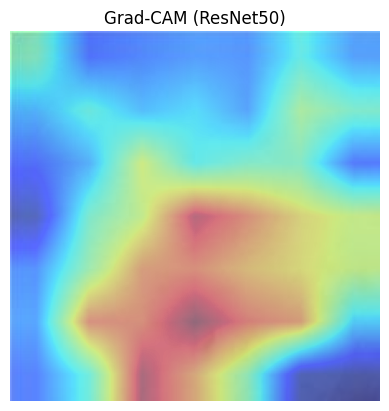

In [48]:
img_path = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg"
img_pil, img_tensor = preprocess(img_path)
cam = generate_gradcam(img_tensor)

# Visualize
import matplotlib.pyplot as plt
plt.imshow(img_pil)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("Grad-CAM (ResNet50)")
plt.show()


In [49]:
import os
from tqdm import tqdm
from torchvision.utils import save_image

def save_gradcam_for_dataset(model, df, image_dir, save_dir, transform, device="cuda"):
    model.eval().to(device)
    os.makedirs(save_dir, exist_ok=True)

    for idx in tqdm(range(len(df))):
        row = df.iloc[idx]
        filename = row.filename
        filepath = os.path.join(image_dir, filename)

        # Load and preprocess image
        img_pil = Image.open(filepath).convert("RGB")
        img_tensor = transform(img_pil).unsqueeze(0).to(device)

        # Generate Grad-CAM
        cam = generate_gradcam(img_tensor)  # returns [H, W], normalized

        # Convert to tensor and save as grayscale PNG
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename.replace(".jpg", ".png"))
        save_image(cam_tensor, save_path)
# Directories
train_cam_dir = "resnet50_cam_heatmaps"
val_cam_dir   = "resnet50_cam_heatmaps_val"

# Run for both
save_gradcam_for_dataset(model, train_df, image_dir, train_cam_dir, transform)
save_gradcam_for_dataset(model, val_df, image_dir, val_cam_dir, transform)


100%|██████████| 400/400 [00:58<00:00,  6.87it/s]


In [50]:
train_cam_dir = "resnet50_cam_heatmaps"
val_cam_dir = "resnet50_cam_heatmaps_val"
fine_mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"


In [51]:
train_cam_dir = "/kaggle/working/resnet50_cam_heatmaps"
val_cam_dir   = "/kaggle/working/resnet50_cam_heatmaps_val"

train_dataset = EnhancedSNDataset(train_df, image_dir, train_cam_dir, fine_mask_dir)
val_dataset   = EnhancedSNDataset(val_df, image_dir, val_cam_dir, fine_mask_dir)


In [52]:

train_enhanced_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_enhanced_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [56]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class ISICClassificationDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row.filename)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row.label_idx)
        return img, label

    def __len__(self):
        return len(self.df)


In [57]:
from sklearn.model_selection import train_test_split

# Assume df has columns: filename, label_idx
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)

train_dataset = ISICClassificationDataset(train_df, image_dir)
val_dataset   = ISICClassificationDataset(val_df, image_dir)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [58]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # ISIC-2017: MEL, NV, BKL
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 11):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for img, label in tqdm(train_loader, desc=f"[Epoch {epoch:02d}] Train"):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == label).sum().item()
        total += label.size(0)

    acc = correct / total
    print(f"[Epoch {epoch:02d}] Train Loss: {train_loss:.4f} | Acc: {acc:.4f}")


[Epoch 01] Train: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


[Epoch 01] Train Loss: 69.7383 | Acc: 0.7069


[Epoch 02] Train: 100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


[Epoch 02] Train Loss: 44.2347 | Acc: 0.8137


[Epoch 03] Train: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


[Epoch 03] Train Loss: 29.3391 | Acc: 0.8894


[Epoch 04] Train: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


[Epoch 04] Train Loss: 17.4696 | Acc: 0.9444


[Epoch 05] Train: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


[Epoch 05] Train Loss: 15.7874 | Acc: 0.9425


[Epoch 06] Train: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


[Epoch 06] Train Loss: 9.8528 | Acc: 0.9650


[Epoch 07] Train: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


[Epoch 07] Train Loss: 5.4537 | Acc: 0.9875


[Epoch 08] Train: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


[Epoch 08] Train Loss: 7.1045 | Acc: 0.9775


[Epoch 09] Train: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


[Epoch 09] Train Loss: 9.1626 | Acc: 0.9613


[Epoch 10] Train: 100%|██████████| 100/100 [01:46<00:00,  1.06s/it]

[Epoch 10] Train Loss: 5.6694 | Acc: 0.9812


In [60]:
torch.save(model.state_dict(), "resnet50_classifier.pth")


In [62]:
!pip install torchcam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00


In [67]:
import torch
import os
from torchvision import models, transforms
from torchcam.methods import GradCAMpp
from PIL import Image
from tqdm import tqdm

# --- Paths ---
image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
train_cam_dir = "/kaggle/working/resnet50_cam_train"
val_cam_dir = "/kaggle/working/resnet50_cam_val"
os.makedirs(train_cam_dir, exist_ok=True)
os.makedirs(val_cam_dir, exist_ok=True)

# --- Load classifier ---
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 3)  # MEL, NV, BKL
model.load_state_dict(torch.load("resnet50_classifier.pth"))
model.eval().cuda()

# --- Define CAM extractor ---
cam_extractor = GradCAMpp(model, target_layer="layer4")

# --- Define image transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- Function to generate and save CAMs ---
def generate_cams(df, cam_dir):
    for row in tqdm(df.itertuples(), total=len(df)):
        filename = row.filename
        label_idx = row.label_idx
        img_path = os.path.join(image_dir, filename)

        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).cuda()

        # Re-instantiate cam_extractor to avoid stale hooks
        cam_extractor = GradCAMpp(model, target_layer="layer4")
        out = model(input_tensor)
        cam = cam_extractor(label_idx, out)

        cam_tensor = cam[0].squeeze().cpu()
        cam_tensor = (cam_tensor - cam_tensor.min()) / (cam_tensor.max() - cam_tensor.min() + 1e-8)

        cam_img = transforms.ToPILImage()(cam_tensor)
        save_path = os.path.join(cam_dir, filename.replace(".jpg", ".png"))
        cam_img.save(save_path)





# --- Generate for train and val ---
generate_cams(train_df, train_cam_dir)
generate_cams(val_df, val_cam_dir)


100%|██████████| 400/400 [01:10<00:00,  5.67it/s]


In [73]:
train_enhanced_dataset = EnhancedSNDataset(
    df=train_df,
    image_dir=image_dir,
    cam_dir="/kaggle/working/resnet50_cam_train",
    mask_dir="/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"
)
val_enhanced_dataset = EnhancedSNDataset(
    df=val_df,
    image_dir=image_dir,
    cam_dir="/kaggle/working/resnet50_cam_val",
    mask_dir="/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"
)

train_enhanced_loader = DataLoader(train_enhanced_dataset, batch_size=8, shuffle=True)
val_enhanced_loader   = DataLoader(val_enhanced_dataset, batch_size=8, shuffle=False)


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedSN(num_classes=2).to(device)

# Binary Cross Entropy Loss (since mask is binary)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

def compute_dice(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    targets = targets.long()
    intersection = ((preds == 1) & (targets == 1)).float().sum()
    union = (preds == 1).float().sum() + (targets == 1).float().sum()
    return (2. * intersection + smooth) / (union + smooth)

def compute_iou(preds, targets, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    targets = targets.long()
    intersection = ((preds == 1) & (targets == 1)).float().sum()
    union = ((preds == 1) | (targets == 1)).float().sum()
    return (intersection + smooth) / (union + smooth)

# Training loop
best_dice = 0.0
for epoch in range(1, 21):
    model.train()
    train_loss, train_dice = 0.0, 0.0

    for img, cam, mask in tqdm(train_enhanced_loader, desc=f"[Epoch {epoch:02d}] Train"):
        img, cam, mask = img.to(device), cam.to(device), mask.to(device).squeeze(1).long()
        optimizer.zero_grad()
        outputs = model(img, cam)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += compute_dice(outputs, mask).item()

    train_loss /= len(train_enhanced_loader)
    train_dice /= len(train_enhanced_loader)

    # Validation
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for img, cam, mask in tqdm(val_enhanced_loader, desc=f"[Epoch {epoch:02d}] Val"):
            img, cam, mask = img.to(device), cam.to(device), mask.to(device).squeeze(1).long()
            outputs = model(img, cam)
            loss = criterion(outputs, mask)

            val_loss += loss.item()
            val_dice += compute_dice(outputs, mask).item()
            val_iou += compute_iou(outputs, mask).item()

    val_loss /= len(val_enhanced_loader)
    val_dice /= len(val_enhanced_loader)
    val_iou  /= len(val_enhanced_loader)

    print(f"\n[Epoch {epoch:02d}] Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} || "
          f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "enhanced_sn_best_resnet.pth")
        print(" Best model saved!\n")


[Epoch 01] Val: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]



[Epoch 01] Train Loss: 0.2684 | Dice: 0.6586 || Val Loss: 0.3270 | Dice: 0.6198 | IoU: 0.4665
 Best model saved!



[Epoch 02] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 02] Train Loss: 0.1849 | Dice: 0.8133 || Val Loss: 0.2841 | Dice: 0.6214 | IoU: 0.4689
 Best model saved!



[Epoch 03] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 03] Train Loss: 0.1650 | Dice: 0.8287 || Val Loss: 0.1987 | Dice: 0.7460 | IoU: 0.6061
 Best model saved!



[Epoch 04] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 04] Train Loss: 0.1490 | Dice: 0.8490 || Val Loss: 0.2457 | Dice: 0.7164 | IoU: 0.5722


[Epoch 05] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 05] Train Loss: 0.1393 | Dice: 0.8548 || Val Loss: 0.1649 | Dice: 0.8068 | IoU: 0.6838
 Best model saved!



[Epoch 06] Val: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



[Epoch 06] Train Loss: 0.1373 | Dice: 0.8604 || Val Loss: 0.1432 | Dice: 0.8447 | IoU: 0.7370
 Best model saved!



[Epoch 07] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 07] Train Loss: 0.1239 | Dice: 0.8753 || Val Loss: 0.1324 | Dice: 0.8567 | IoU: 0.7543
 Best model saved!



[Epoch 08] Val: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



[Epoch 08] Train Loss: 0.1180 | Dice: 0.8772 || Val Loss: 0.1488 | Dice: 0.8326 | IoU: 0.7191


[Epoch 09] Val: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



[Epoch 09] Train Loss: 0.1121 | Dice: 0.8798 || Val Loss: 0.1212 | Dice: 0.8693 | IoU: 0.7727
 Best model saved!



[Epoch 10] Val: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



[Epoch 10] Train Loss: 0.1041 | Dice: 0.8922 || Val Loss: 0.1228 | Dice: 0.8744 | IoU: 0.7809
 Best model saved!



[Epoch 11] Val: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



[Epoch 11] Train Loss: 0.1043 | Dice: 0.8904 || Val Loss: 0.1469 | Dice: 0.8357 | IoU: 0.7228


[Epoch 12] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 12] Train Loss: 0.1018 | Dice: 0.8922 || Val Loss: 0.1128 | Dice: 0.8688 | IoU: 0.7711


[Epoch 13] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 13] Train Loss: 0.0968 | Dice: 0.8950 || Val Loss: 0.1192 | Dice: 0.8775 | IoU: 0.7846
 Best model saved!



[Epoch 14] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 14] Train Loss: 0.0956 | Dice: 0.8979 || Val Loss: 0.1310 | Dice: 0.8542 | IoU: 0.7496


[Epoch 15] Val: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]



[Epoch 15] Train Loss: 0.0916 | Dice: 0.8992 || Val Loss: 0.1240 | Dice: 0.8679 | IoU: 0.7707


[Epoch 16] Val: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]



[Epoch 16] Train Loss: 0.0901 | Dice: 0.9020 || Val Loss: 0.1159 | Dice: 0.8795 | IoU: 0.7881
 Best model saved!



[Epoch 17] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 17] Train Loss: 0.0905 | Dice: 0.8989 || Val Loss: 0.1172 | Dice: 0.8868 | IoU: 0.7995
 Best model saved!



[Epoch 18] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]



[Epoch 18] Train Loss: 0.0844 | Dice: 0.9081 || Val Loss: 0.1064 | Dice: 0.8890 | IoU: 0.8030
 Best model saved!



[Epoch 19] Val: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]



[Epoch 19] Train Loss: 0.0845 | Dice: 0.9072 || Val Loss: 0.1135 | Dice: 0.8814 | IoU: 0.7908


[Epoch 20] Val: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


[Epoch 20] Train Loss: 0.0842 | Dice: 0.9085 || Val Loss: 0.1115 | Dice: 0.8877 | IoU: 0.8013


  0%|          | 0/50 [00:00<?, ?it/s]

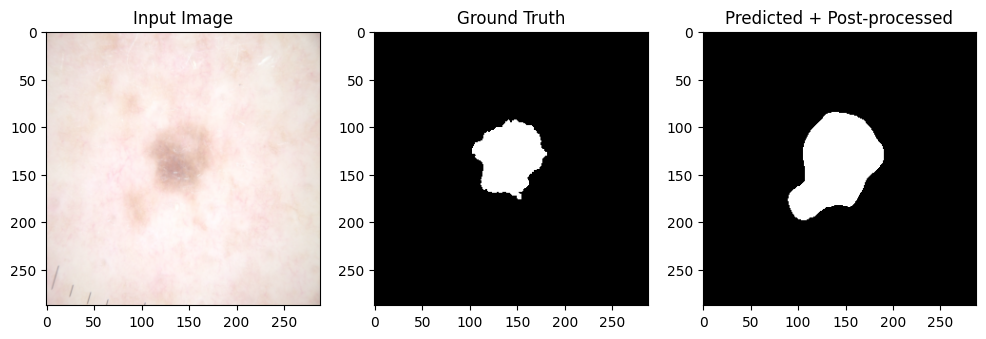

  2%|▏         | 1/50 [00:02<02:02,  2.49s/it]

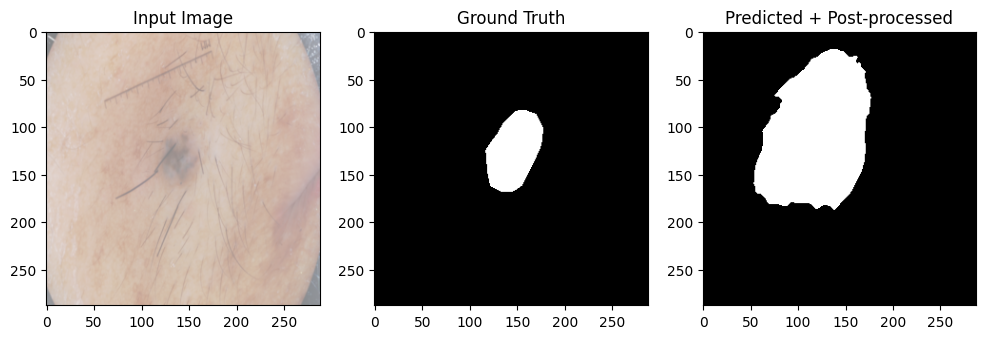

  4%|▍         | 2/50 [00:04<01:52,  2.34s/it]

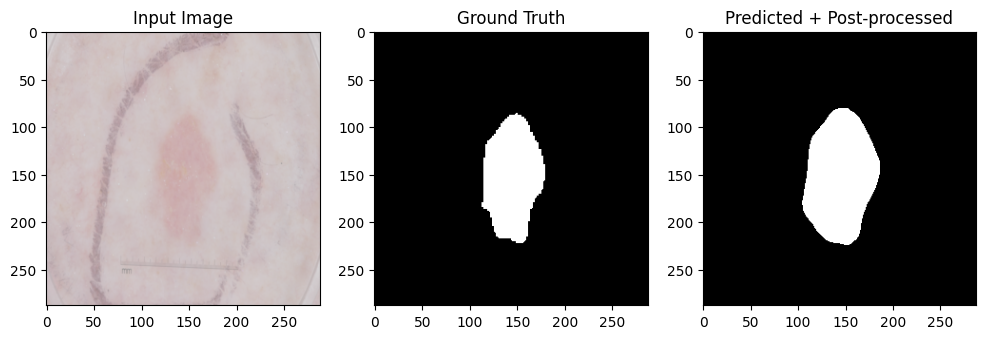

100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


 Avg Dice: 0.8797
 Avg Jaccard: 0.8037


In [76]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

def post_process_mask(mask):
    mask = mask.astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return (mask > 127).astype(np.uint8)

# ---------- TTA for EnhancedSN ----------
def apply_tta_enhancedsn(model, image, cam):
    flips = [
        (lambda x: x, lambda x: x),
        (TF.hflip, TF.hflip),
        (TF.vflip, TF.vflip),
        (lambda x: TF.vflip(TF.hflip(x)), lambda x: TF.hflip(TF.vflip(x)))
    ]

    preds = []
    for f_aug, f_inv in flips:
        img_aug = f_aug(image)
        cam_aug = f_aug(cam)

        img_aug = img_aug.unsqueeze(0).to("cuda")
        cam_aug = cam_aug.unsqueeze(0).to("cuda")

        out = model(img_aug, cam_aug)
        out = torch.softmax(out, dim=1)
        out_inv = f_inv(out.squeeze(0).cpu())
        preds.append(out_inv)

    avg_pred = torch.stack(preds).mean(dim=0, keepdim=True)
    return avg_pred

# ---------- Evaluation ----------
dice_scores = []
jaccard_scores = []

model.load_state_dict(torch.load("enhanced_sn_best_resnet.pth", map_location="cuda"))
model.eval().cuda()

with torch.no_grad():
    for idx, (image, cam, mask) in enumerate(tqdm(val_enhanced_loader)):
        image = image.to("cuda")  # [B, 3, H, W]
        cam = cam.to("cuda")      # [B, 1, H, W]
        mask = mask.to("cuda")    # [B, 1, H, W]

        for b in range(image.size(0)):
            img = image[b]
            cm = cam[b]
            gt = mask[b].squeeze().cpu().numpy()

            # Apply TTA with CAM
            output = apply_tta_enhancedsn(model, img, cm)  # (1, C, H, W)
            pred = torch.argmax(output, dim=1).squeeze(0).numpy()

            # Post-process
            pred_post = post_process_mask(pred)

            # Dice & Jaccard
            intersection = np.logical_and(pred_post == 1, gt == 1).sum()
            union = np.logical_or(pred_post == 1, gt == 1).sum()
            dice = (2 * intersection) / (np.sum(pred_post) + np.sum(gt) + 1e-6)
            jaccard = intersection / (union + 1e-6)

            dice_scores.append(dice)
            jaccard_scores.append(jaccard)

            # Show first 3
            if idx < 3 and b == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
                plt.title("Input Image")
                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth")
                plt.subplot(1, 3, 3)
                plt.imshow(pred_post, cmap='gray')
                plt.title("Predicted + Post-processed")
                plt.show()

# ---------- Final Scores ----------
print(f"\n Avg Dice: {np.mean(dice_scores):.4f}")
print(f" Avg Jaccard: {np.mean(jaccard_scores):.4f}")
